<h1 align="center"><font size="5">Рекомендация фильмов, используя RBM</font></h1>

In [2]:
#импортируем библиотеки 
import tensorflow as tf #для работы с нейронными сетями 
import numpy as np #для работы с массивами 
import pandas as pd #Чтение, обратотка данных
import matplotlib.pyplot as plt #для графиков 
%matplotlib inline #гарфик в ячейку кода а не отдельно 

In [4]:
#импоритруем наши данные для ФИЛЬМОВ
#у нас файл с расширение dat и там разделение :: а не запятая, поэтому мы пишем такие параметры
movies_df = pd.read_csv('ml-1m/movies.dat', sep='::', header=None, engine='python') 
movies_df.head() #выводим первые зачения наших данных 

,0,1,2
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


In [5]:
#импоритруем наши данные для ОЦЕНОК фильмов
ratings_df = pd.read_csv('ml-1m/ratings.dat', sep='::', header=None, engine='python')
ratings_df.head() #выводим первые зачения наших данных 

,0,1,2,3
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


Поменяем названия столбцов на более понятные: 

In [6]:
movies_df.columns = ['MovieID', 'Title', 'Genres']
movies_df.head()

,MovieID,Title,Genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


In [7]:
ratings_df.columns = ['UserID', 'MovieID', 'Rating', 'Timestamp']
ratings_df.head()

,UserID,MovieID,Rating,Timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


<h3>Форматирование данных</h3>

In [9]:
#создаём датафрейм со сводными значениями оценок каждого пользователя для каждого фильма 
user_rating_df = ratings_df.pivot(index='UserID', columns='MovieID', values='Rating') 
user_rating_df.head() #выводим первые значения 

MovieID,1,2,3,4,5,6,7,8,9,10,...,3943,3944,3945,3946,3947,3948,3949,3950,3951,3952
UserID,,,,,,,,,,,,,,,,,,,,,
1,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Мы видим, что у нас много пустых значений, поэтому заполняем их нулями. Ноль будет значит что пользователь не смотрел фильм.
Затем нормализуем. 
Нормализуем за тем чтобы было легче сравнивать зачения и нашей нейронной сети было лечге работать с ними. 

In [26]:
norm_user_rating_df = user_rating_df.fillna(0) / 5.0 #заполняем нулями и делим на 5 
trX = norm_user_rating_df.values #возвращем массив значений датафрейма 
trX[0:5] #выводим первые 5 строчек 

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

<a id="ref4"></a>
<h2>Создание модели</h2>

### Сначала задаём параметры модели и архитектуру слоёв:

In [11]:
hiddenUnits = 20 #определяем количество нейронов в скрытых уровнях 
visibleUnits =  len(user_rating_df.columns) #кол-во видимых нейронов равняется количеству фильмов 

#создаём переменные для хранения нейронов смещения 
vb = tf.Variable(tf.zeros([visibleUnits]), tf.float32) #для видимых слоёв (количество уникальных фильмов)
hb = tf.Variable(tf.zeros([hiddenUnits]), tf.float32) #для скрытых слоёв (количество признаков которые мы собираемся выучить)
W = tf.Variable(tf.zeros([visibleUnits, hiddenUnits]), tf.float32) #веса, которые соединяют скрытый слой с видимым слоем

In [28]:
v0 = tf.zeros([visibleUnits], tf.float32) #переменная исходного вектора 
tf.matmul([v0], W) #проверяем работает ли умножение матриц для нейронов видимых слоёв и весов 

<tf.Tensor: shape=(1, 20), dtype=float32, numpy=
array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.]], dtype=float32)>

Затем мы переходим к созданию видимых и скрытых элементов слоя и настройке их функций активации. В этом случае мы будем использовать функции <code> tf.sigmoid </code> и <code> tf.relu </code> в качестве нелинейных активаций, поскольку они обычно используются в RBM.

In [13]:
#определение функции, возвращающей только сгенерированные скрытые состояния
def hidden_layer(v0_state, W, hb):
    h0_prob = tf.nn.sigmoid(tf.matmul([v0_state], W) + hb)  # вероятности скрытых элементов
    h0_state = tf.nn.relu(tf.sign(h0_prob - tf.random.uniform(tf.shape(h0_prob)))) #определяем сгенерированное скрытое сост-е
    return h0_state

#можно не говорить 
h0 = hidden_layer(v0, W, hb) #вызываем функцию для нулей и определяем параметр h0
print("first 15 hidden states: ", h0[0][0:15]) #выводим первые 15 скрытых состояний для нулей

#определяем функция вывода 
def reconstructed_output(h0_state, W, vb):
    v1_prob = tf.nn.sigmoid(tf.matmul(h0_state, tf.transpose(W)) + vb) # вероятности видимых элементов
    v1_state = tf.nn.relu(tf.sign(v1_prob - tf.random.uniform(tf.shape(v1_prob))))  #определяем сгенерированное видимое сост-е
    return v1_state[0]

#можно не говорить
v1 = reconstructed_output(h0, W, vb)  #вызываем функцию и определяем параметр h0
print("hidden state shape: ", h0.shape) #выводим размер скрытого состояния 
#лучше не говорить :()
print("v0 state shape:  ", v0.shape) #размер состояния для исходного вектора 
print("v1 state shape:  ", v1.shape) #размер состояния для видимого слоя  

first 15 hidden states:  tf.Tensor([1. 1. 0. 0. 1. 1. 1. 1. 0. 0. 1. 0. 1. 0. 1.], shape=(15,), dtype=float32)
hidden state shape:  (1, 20)
v0 state shape:   (3706,)
v1 state shape:   (3706,)


Задаём функцию ошибок MAE. MAE - Mean Absolute Error, Средняя абсолютная ошибка.

In [24]:
def error(v0_state, v1_state):
    return tf.reduce_mean(tf.square(v0_state - v1_state)) #использум встроенную функцию сокращённого среднего для быстроты выч-я

### Дальше происходит непосредственно обучение модели: 

Epoch: 1 batch #: 0  of 12 sample #: 499 reconstruction error: 0.044047
Epoch: 1 batch #: 1  of 12 sample #: 499 reconstruction error: 0.030772
Epoch: 1 batch #: 2  of 12 sample #: 499 reconstruction error: 0.039126
Epoch: 1 batch #: 3  of 12 sample #: 499 reconstruction error: 0.031193
Epoch: 1 batch #: 4  of 12 sample #: 499 reconstruction error: 0.047480
Epoch: 1 batch #: 5  of 12 sample #: 499 reconstruction error: 0.032078
Epoch: 1 batch #: 6  of 12 sample #: 499 reconstruction error: 0.025958
Epoch: 1 batch #: 7  of 12 sample #: 499 reconstruction error: 0.026875
Epoch: 1 batch #: 8  of 12 sample #: 499 reconstruction error: 0.003270
Epoch: 1 batch #: 9  of 12 sample #: 499 reconstruction error: 0.110901
Epoch: 1 batch #: 10  of 12 sample #: 499 reconstruction error: 0.018230
Epoch: 1 batch #: 11  of 12 sample #: 499 reconstruction error: 0.098489
Epoch: 1 batch #: 12  of 12 sample #: 39 reconstruction error: 0.073211
Epoch: 2 batch #: 0  of 12 sample #: 499 reconstruction error:

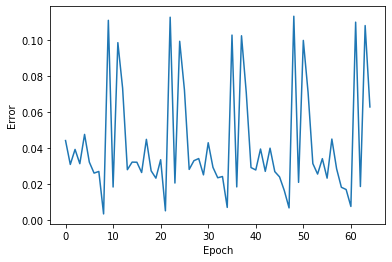

In [15]:
epochs = 5 #задаём 5 эпох, то есть данные будут показаны нашей модели 5 раз 
batchsize = 500 #задаём размер пакета 500
errors = [] #пустой список для ошибок 
weights = [] #пустой список для весов 
K=1
alpha = 0.1 #параметр для расчёта весов 

train_ds = \
    tf.data.Dataset.from_tensor_slices((np.float32(trX))).batch(batchsize) #создаём датасет и формируем пакет 


v0_state=v0 #состояние для исходного вектора 
for epoch in range(epochs): #повторяем цикл 5 раз 
    batch_number = 0 #номер пакета
    for batch_x in train_ds:

        for i_sample in range(len(batch_x)):           
            for k in range(K): 
                v0_state = batch_x[i_sample] #исходный вектор состояний видимого слоя 
                h0_state = hidden_layer(v0_state, W, hb) #нулевой вектор состояний скрытого слоя
                v1_state = reconstructed_output(h0_state, W, vb) #обновлённый вектор видимого слоя 
                h1_state = hidden_layer(v1_state, W, hb) #обновлённый вектор скрытого слоя 

                #Матрица обновлений весов с помощью констрастной дивергенции:
                delta_W = tf.matmul(tf.transpose([v0_state]), h0_state) - tf.matmul(tf.transpose([v1_state]), h1_state)
                #новые веса расчитываем с помощью матрицы обновления с градиентным подьёмом 
                W = W + alpha * delta_W

                vb = vb + alpha * tf.reduce_mean(v0_state - v1_state, 0) #нейроны смещения для видимых слоёв 
                hb = hb + alpha * tf.reduce_mean(h0_state - h1_state, 0) #нейроны смещения для скрытых слоёв

                v0_state = v1_state #от исходного вектора состояний переходим к новому 

            #выводим значения ошибки для каждого пакета каждой эпохи 
            if i_sample == len(batch_x)-1:
                err = error(batch_x[i_sample], v1_state) #вызываем функцию ошибок 
                errors.append(err) #добавляем ошибку в список 
                weights.append(W) #добавляем вес в список 
                print ( 'Epoch: %d' % (epoch + 1), #эпохи 
                       "batch #: %i " % batch_number, "of %i" % (len(trX)/batchsize), #номер пакета 
                       "sample #: %i" % i_sample, #выборка
                       'reconstruction error: %f' % err) #ошибка 
        batch_number += 1 #обновление номера пакета 




plt.plot(errors) #выводим график функции ошибок 
plt.ylabel('Error') #по игреку ошибки 
plt.xlabel('Epoch') #по иксу эпохи
plt.show()

<a id="ref5"></a>
<h2>Рекомендация</h2>

### Здесь мы просто выбираем рандомного пользователя и делаем подборку из 20 фильмов для него

Выеберем <b>User ID</b> одного из наших пользователей:

In [16]:
#выбираем пользователя с айди 215
mock_user_id = 215

In [17]:
inputUser = trX[mock_user_id-1].reshape(1, -1) #из матрицы исходных данных выбираем значения только для айди 215

inputUser = tf.convert_to_tensor(trX[mock_user_id-1],"float32") #превращаем в тензор 
v0 = inputUser #задаём начальное состояние 

print(v0) #смотрим на начальные значения для нашего пользователя 
v0.shape

tf.Tensor([0.8 0.  0.  ... 0.  0.  0. ], shape=(3706,), dtype=float32)


TensorShape([3706])

In [31]:
v0test = tf.zeros([visibleUnits], tf.float32) #задаём тестовый тензор нулей для видимых нейронов
v0test.shape #выводим его размер 

TensorShape([3706])

In [19]:
hh0 = tf.nn.sigmoid(tf.matmul([v0], W) + hb) #применяем нейронную сеть для скрытого слоя 

vv1 = tf.nn.sigmoid(tf.matmul(hh0, tf.transpose(W)) + vb) #применяем нейронную сеть для видимого слоя

rec = vv1 #вводим переменную рекомендация равную выводу нейронной сети 

tf.maximum(rec,1) #обохим значения рекомендации и выводим тензор 
for i in vv1:
    print(i)

tf.Tensor([0.09750101 0.03824031 0.00627953 ... 0.00028762 0.00033563 0.00042245], shape=(3706,), dtype=float32)


Теперь мы можем вывести список из 20 рекомендованных фильмов: 

In [20]:
scored_movies_df_mock = movies_df[movies_df['MovieID'].isin(user_rating_df.columns)] #берм исходный список фильмов 
#у которых есть рейтинг
scored_movies_df_mock = scored_movies_df_mock.assign(RecommendationScore = rec[0]) #добавляем показатель рекомендации 
scored_movies_df_mock.sort_values(["RecommendationScore"], ascending=False).head(20) #сортируем от более рекомендованных к менее
#и выводим первые 20

,MovieID,Title,Genres,RecommendationScore
1220,1240,"Terminator, The (1984)",Action|Sci-Fi|Thriller,0.802012
1081,1097,E.T. the Extra-Terrestrial (1982),Children's|Drama|Fantasy|Sci-Fi,0.771726
2847,2916,Total Recall (1990),Action|Adventure|Sci-Fi|Thriller,0.723690
1178,1196,Star Wars: Episode V - The Empire Strikes Back...,Action|Adventure|Drama|Sci-Fi|War,0.711313
2693,2762,"Sixth Sense, The (1999)",Thriller,0.681565
1543,1584,Contact (1997),Drama|Sci-Fi,0.653270
1539,1580,Men in Black (1997),Action|Adventure|Comedy|Sci-Fi,0.641467
2559,2628,Star Wars: Episode I - The Phantom Menace (1999),Action|Adventure|Fantasy|Sci-Fi,0.640604
476,480,Jurassic Park (1993),Action|Adventure|Sci-Fi,0.613688
1192,1210,Star Wars: Episode VI - Return of the Jedi (1983),Action|Adventure|Romance|Sci-Fi|War,0.603146
